<a href="https://colab.research.google.com/github/kimhj010502/ESAA_OB/blob/main/%EC%BA%90%EA%B8%80_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras CNN Dog or Cat Classification
https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification

## Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir 'input'
!mkdir 'input/train'
!mkdir 'input/test'

In [3]:
!unzip -qq "/content/drive/MyDrive/ESAA/OB/Data/DogorCatClassification/train_700" -d '/content/input/train'
!unzip -qq "/content/drive/MyDrive/ESAA/OB/Data/DogorCatClassification/test_500" -d '/content/input/test'

In [4]:
import tensorflow
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/content/input"))

['train', 'test']


## Define Constants

In [5]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [6]:
filenames = os.listdir("/content/input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,dog.639.jpg,1
1,dog.399.jpg,1
2,cat.360.jpg,0
3,cat.277.jpg,0
4,dog.578.jpg,1


In [8]:
df.tail

<bound method NDFrame.tail of          filename  category
0     dog.639.jpg         1
1     dog.399.jpg         1
2     cat.360.jpg         0
3     cat.277.jpg         0
4     dog.578.jpg         1
...           ...       ...
1397   dog.98.jpg         1
1398  cat.623.jpg         0
1399  dog.269.jpg         1
1400  dog.284.jpg         1
1401    dog.1.jpg         1

[1402 rows x 2 columns]>

### See Total in count

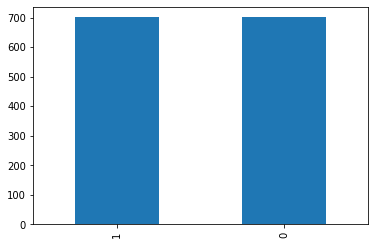

In [9]:
df['category'].value_counts().plot.bar()

## See sample image

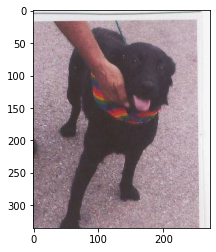

In [10]:
sample = random.choice(filenames)
image = load_img("/content/input/train/"+sample)
plt.imshow(image)

## Build Model <br>
<a href='https://ifh.cc/v-TYLj8A' target='_blank'><img src='https://ifh.cc/g/TYLj8A.jpg' border='0'></a>
- <b>Input Layer</b>: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
- <b>Conv Layer</b>: This layer will extract features from image.
Pooling Layer: This layerreduce the spatial volume of input image after convolution.
- <b>Fully Connected Layer</b>: It connect the network from a layer to another layer
- <b>Output Layer</b>: It is the predicted values layer.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## Callbacks

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stop

In [13]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

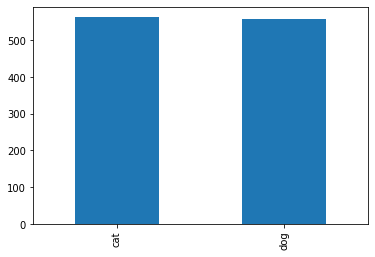

In [18]:
train_df['category'].value_counts().plot.bar()

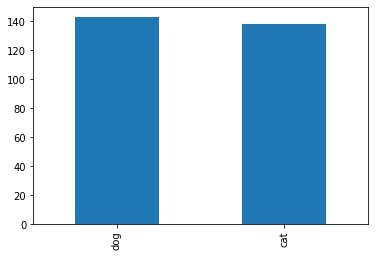

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


### Validation Generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


## See how our generator work

In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


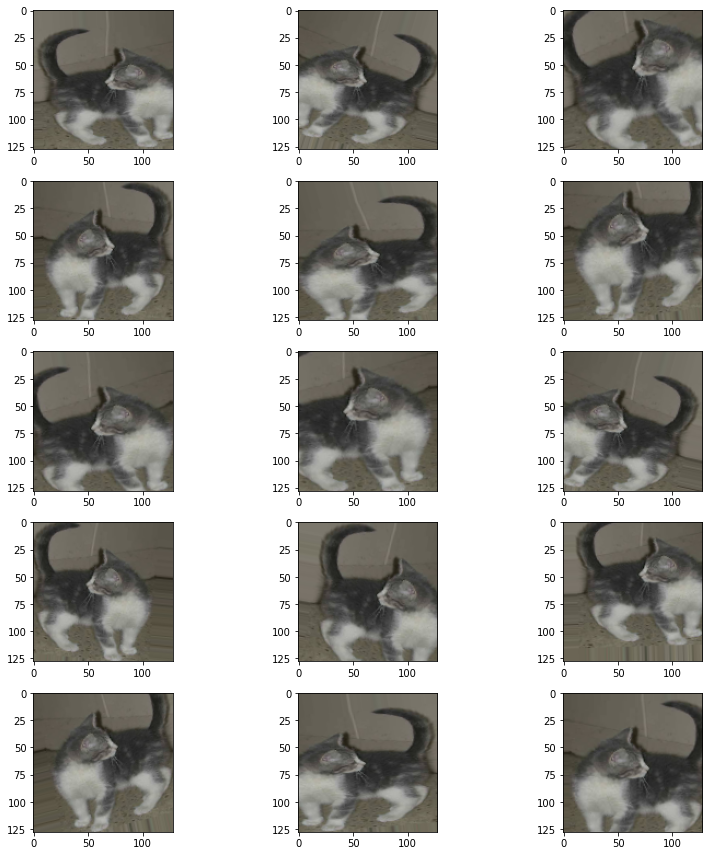

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [25]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-25-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
74/74 [==============================] - ETA: 0s - loss: 1.3837 - accuracy: 0.5723

74/74 [==============================] - 63s 826ms/step - loss: 1.3837 - accuracy: 0.5723 - val_loss: 4.6585 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 2/3
74/74 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.5931

74/74 [==============================] - 58s 784ms/step - loss: 1.0821 - accuracy: 0.5931 - val_loss: 3.2317 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 3/3
74/74 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.5759

74/74 [==============================] - 60s 806ms/step - loss: 0.9373 - accuracy: 0.5759 - val_loss: 1.9627 - val_accuracy: 0.4889 - lr: 0.0010


## Save Model

In [26]:
model.save_weights("model.h5")

## Virtualize Training

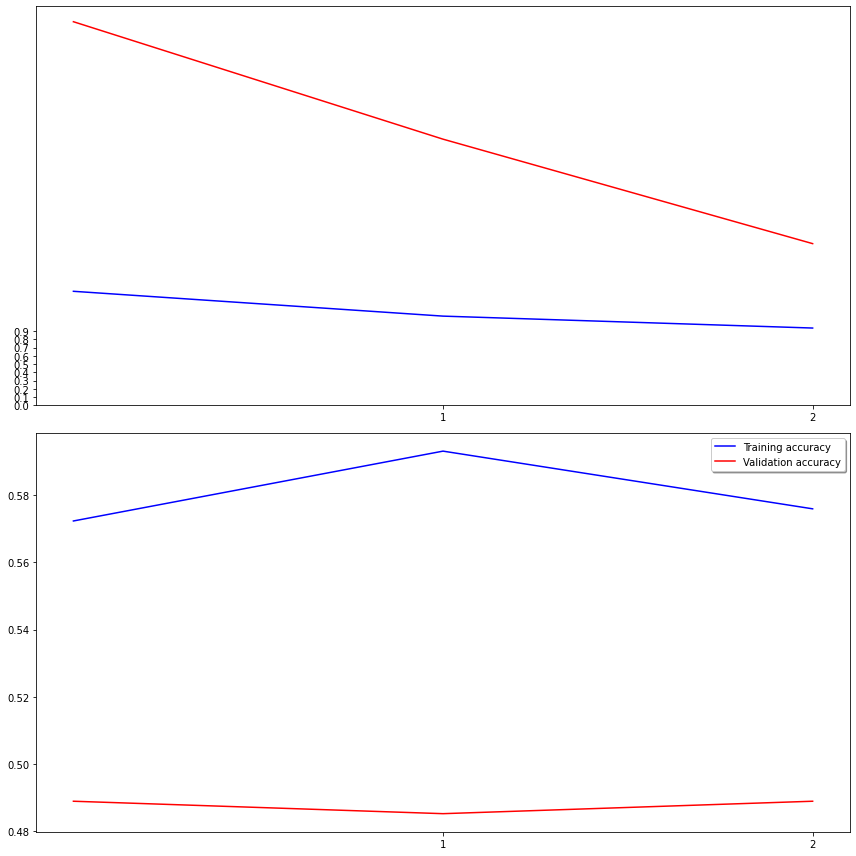

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [29]:
test_filenames = os.listdir("/content/input/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/input/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


## Predict

In [31]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-31-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [32]:
test_df['category'] = np.argmax(predict, axis=-1)

In [33]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [34]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtualize Result

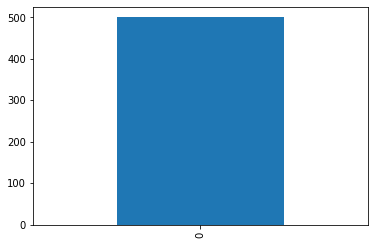

In [35]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

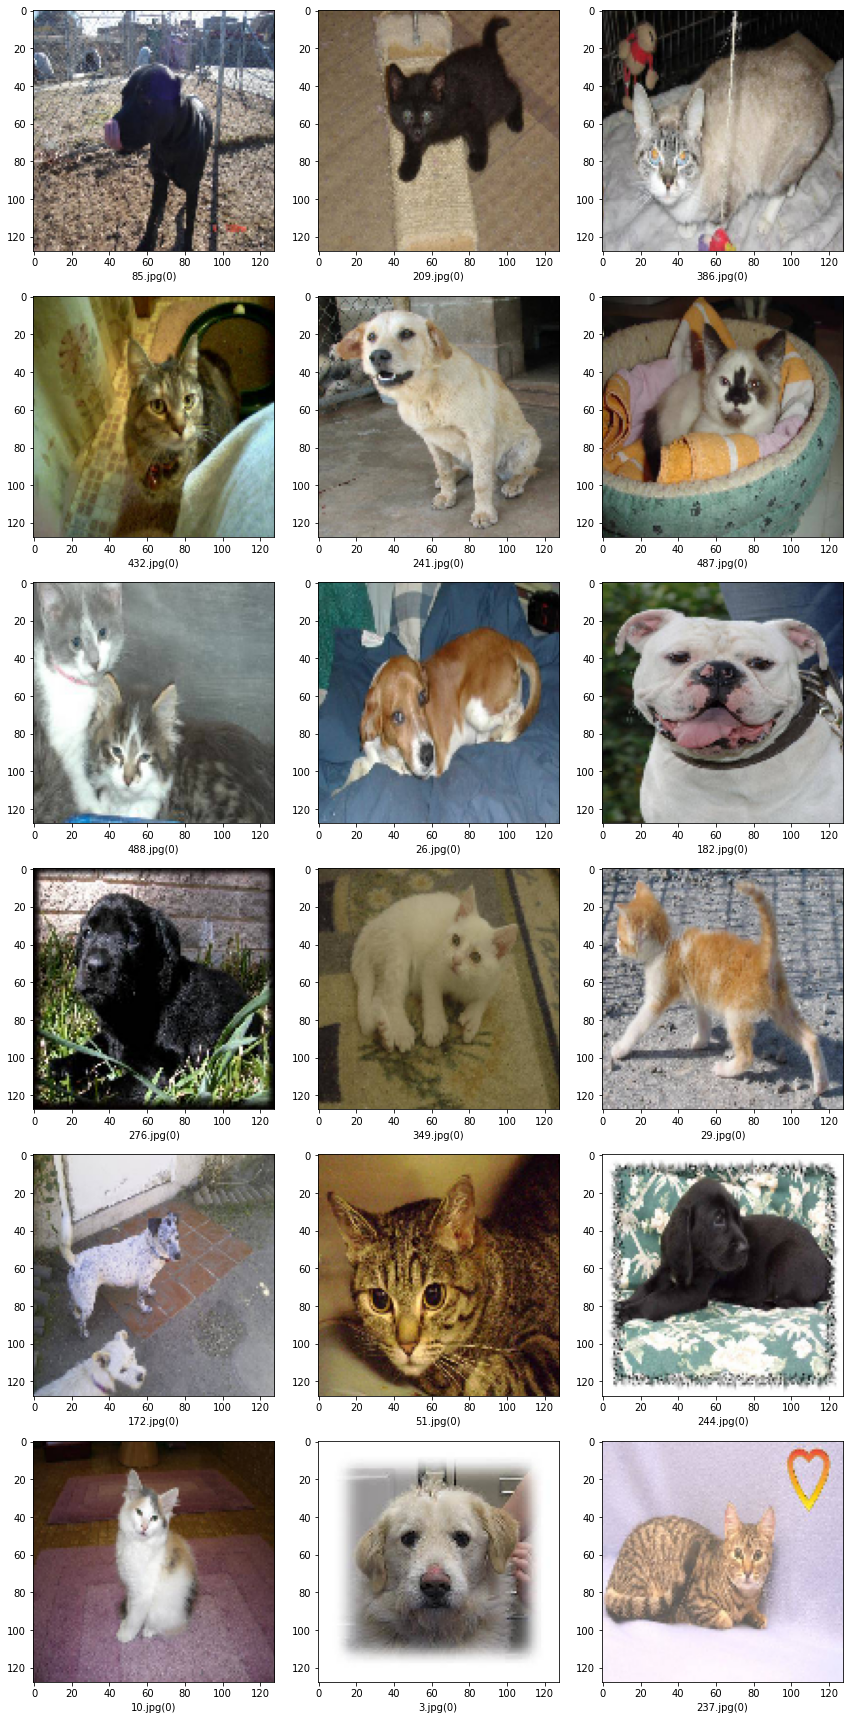

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/input/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### Submission

In [38]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)